# Lesson 3: The Sequential Network

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch.optim import SGD

## Last lesson:
We tried to find a function such $f(x_i) = y_i$ we choose it to have the form:

$$f(x) = M_2 M_1 x$$

where $M_1$ is a 8x2 matrix and $M_2$ is a 1x8 matrix. We did this in order to have $16 + 8$ free parameters, but the predictions we got were not really accurate.

In [11]:
# Lesson 2 NN
x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

class MyNeuralNet(nn.Module):
    # nn.Module is called as a super class
    def __init__(self):
        super().__init__() # initializing the super module
        self.Matrix1 = nn.Linear(2, 8, bias = False)
        self.Matrix2 = nn.Linear(8, 1, bias = False)  
    def forward(self, x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()
    
f = MyNeuralNet()
opt = SGD(f.parameters(), lr = 0.001)
L = nn.MSELoss()

# Train model
losses = []
for _ in range(50):
    opt.zero_grad()
    loss_value = L(f(x), y) # compute loss
    loss_value.backward() # compute gradient
    opt.step() # perform iteration using gradient above
    losses.append(loss_value.item())

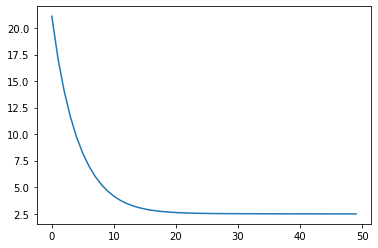

In [12]:
fig, ax = plt.subplots()
ax.plot(losses)
plt.show()

## Why did we get inaccurate predictions?

Although there were $24$ parameters in the two matrices, since they were operating in the fashion

$$M_2 M_1 = B$$

$B$ results in 1x2 matrix so there were really **only two independent parameters** which insufficient to solve the problem accurately

### Advance machine learning models thanks to linear algebra simplicity:

**The crux of machine learning** is using the simplicity of linear algebra (matrices and vector operations to transform data), this lies on the so-called activation fuction (avoiding the matrices collapsing into just one matrix like before)
* **Old model:** $$f(x) = M_2 M_1 x$$
* **New model:** $$f(x) = M_2 R(M_1 x)$$

where $R$ is an element-wise operator defined by

$$
\begin{equation}
R(x)=\Bigg\{ 
\begin{split}
&x \quad x > 0 \\
&0 \quad x \leq 0
\end{split}
\end{equation}
$$

We can observe the behaviour of this activation function:

In [13]:
x = torch.tensor([[1,2,-2,1,-5,-1,6], [-2,2,2,-6,5,-1,6]])
x

tensor([[ 1,  2, -2,  1, -5, -1,  6],
        [-2,  2,  2, -6,  5, -1,  6]])

In [14]:
R = nn.ReLU()
R(x)

tensor([[1, 2, 0, 1, 0, 0, 6],
        [0, 2, 2, 0, 5, 0, 6]])

#### Does our model improve with this simple adjustment?

In [15]:
class MyNeuralNet2(nn.Module):
    # nn.Module is called as a super class
    def __init__(self):
        super().__init__() # initializing the super module
        self.Matrix1 = nn.Linear(2, 8, bias = False)
        self.Matrix2 = nn.Linear(8, 1, bias = False)
        self.R = nn.ReLU()
    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

In [16]:
def train_model(x, y, f, n_epochs = 50):
    opt = SGD(f.parameters(), lr = 0.001)
    L = nn.MSELoss()

    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()
        loss_value = L(f(x), y) # compute loss
        loss_value.backward() # compute gradient
        opt.step() # perform iteration using gradient above
        losses.append(loss_value.item())
    
    return f, losses

In [17]:
x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f2 = MyNeuralNet2()
f2, losses2 = train_model(x, y, f2, n_epochs = 5000)

Looking the predictions

In [18]:
y

tensor([1., 5., 2., 5.])

In [19]:
f2(x)

tensor([2.3560, 2.9681, 1.9378, 5.2608], grad_fn=<SqueezeBackward0>)

### Real advantage of non-linearity: Much larger matrices.
Now that the parameters are trully independent thanks to the use of $R(x)$

In [20]:
class MyNeuralNet3(nn.Module):
    # lets try 240 parameters
    def __init__(self):
        super().__init__() # initializing the super module
        self.Matrix1 = nn.Linear(2, 80, bias = False) # 80x2 
        self.Matrix2 = nn.Linear(80, 1, bias = False) # 1x80 
        self.R = nn.ReLU()
    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

In [21]:
f3 = MyNeuralNet3()
f3, losses3 = train_model(x, y, f3, n_epochs = 5000)

Predictions:

In [22]:
y

tensor([1., 5., 2., 5.])

In [23]:
f3(x)

tensor([2.0141, 3.5955, 1.9459, 5.1629], grad_fn=<SqueezeBackward0>)

**Comparisson of the models**

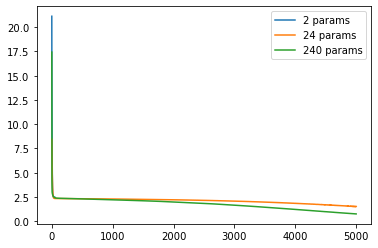

In [24]:
fig, ax = plt.subplots()
ax.plot(losses, label = '2 params')
ax.plot(losses2, label = '24 params')
ax.plot(losses3, label = '240 params')
ax.legend()
plt.show()

### Bias vectors:
We can make our models even better introducing more parameters:

$$f(x) = A_2 R(A_1 x + b_1) + b_2$$

where $b_1$ and $b_2$ are vectors added to each of the linear transformations.

* **Old model:** $$f(x) = A_2 R(A_1 x)$$
* **New model:** $$f(x) = A_2 R(A_1 x + b_1) + b_2$$
keeping $A_2$ a $1x80$ matrix and $A_1$ a $80x2$ matrix

In [25]:
class MyNeuralNet4(nn.Module):
    # lets try 240 parameters
    def __init__(self):
        super().__init__() # initializing the super module
        self.Matrix1 = nn.Linear(2, 80) # bias is set to true by default
        self.Matrix2 = nn.Linear(80, 1) 
        self.R = nn.ReLU()
    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.Matrix2(x)
        return x.squeeze()

In [26]:
f4 = MyNeuralNet4()
f4, losses4 = train_model(x, y, f4, n_epochs = 5000)

predictions

In [27]:
y

tensor([1., 5., 2., 5.])

In [28]:
f4(x)

tensor([1.3737, 4.5032, 2.0065, 5.0335], grad_fn=<SqueezeBackward0>)

### Overfitting?

* **Old model:** $$f(x) = A_2 R(A_1 x + b_1) + b_2$$
* **New model:** $$f(x) = A_3 R(A_2 R(A_1 x + b_1) + b_2)$$ where $A_2$ is a $80x80$ matrix and $A_3$ is $1x80$

In [29]:
class MyNeuralNet5(nn.Module):
    def __init__(self):
        super().__init__() # initializing the super module
        self.Matrix1 = nn.Linear(2, 80) # bias is set to true by default
        self.Matrix2 = nn.Linear(80, 80) 
        self.Matrix3 = nn.Linear(80, 1) 
        self.R = nn.ReLU()
        
    def forward(self, x):
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [30]:
x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f5 = MyNeuralNet5()
f5, losses5 = train_model(x, y, f5, n_epochs = 5000)

predictions

In [31]:
y

tensor([1., 5., 2., 5.])

In [32]:
f5(x)

tensor([1.0006, 4.9990, 2.0000, 4.9999], grad_fn=<SqueezeBackward0>)

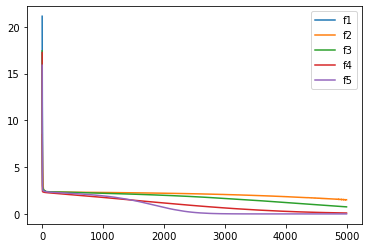

In [33]:
fig, ax = plt.subplots()
ax.plot(losses, label = 'f1')
ax.plot(losses2, label = 'f2')
ax.plot(losses3, label = 'f3')
ax.plot(losses4, label = 'f4')
ax.plot(losses5, label = 'f5')
ax.legend()
plt.show()

### The sequential Neural Network

A mathematical way of describing the structure we have been using is

$$
f(x) = {\huge\kappa}^{n}_{i=1} R_i (A_i x + b_i)
$$

where ${\huge\kappa}^{n}_{i=1} f_i(x) = f_n \circ f_{n-1} \circ ... \circ  f_1 (x)$